In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 1.99M/1.99M [00:00<00:00, 3.10MB/s]

Extracting files...
Path to dataset files: C:\Users\Allaa Azzam\.cache\kagglehub\datasets\jp797498e\twitter-entity-sentiment-analysis\versions\2


In [2]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from datasets import Dataset
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'transformers'

In [3]:
train_df = pd.read_csv(path + "/twitter_training.csv", header=None)
val_df = pd.read_csv(path + "/twitter_validation.csv", header=None)

In [4]:
train_df.columns =['ID','entity','sentiment','tweet_content']
val_df.columns =['ID','entity','sentiment','tweet_content']

In [5]:
train_df = train_df.dropna()
val_df = val_df.dropna()

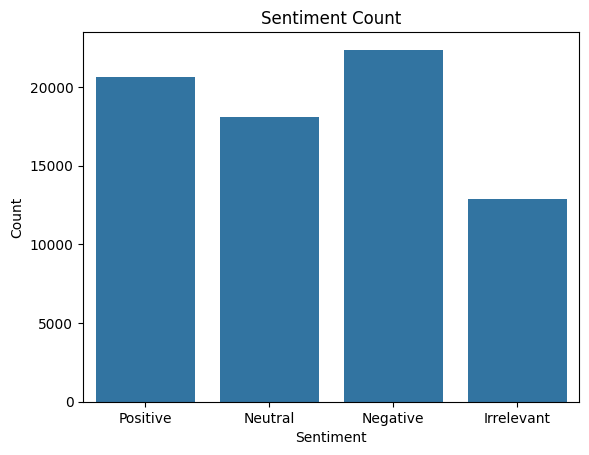

In [6]:
sns.countplot(data = train_df, x = 'sentiment')
plt.title('Sentiment Count')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [7]:
train_df = train_df.drop(columns = ['ID', 'entity'], axis=1)
val_df = val_df.drop(columns = ['ID', 'entity'], axis=1)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentiment      73996 non-null  object
 1   tweet_content  73996 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [13]:
train_df.head(30)

,sentiment,tweet_content
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
5,Positive,im getting into borderlands and i can murder y...
6,Positive,So I spent a few hours making something for fu...
7,Positive,So I spent a couple of hours doing something f...
8,Positive,So I spent a few hours doing something for fun...
9,Positive,So I spent a few hours making something for fu...


In [14]:
label_encoder = LabelEncoder()
train_df['sentiment'] = label_encoder.fit_transform(train_df['sentiment'])
val_df['sentiment'] = label_encoder.transform(val_df['sentiment'])

In [15]:
train_df.head(30)

,sentiment,tweet_content
0,3,im getting on borderlands and i will murder yo...
1,3,I am coming to the borders and I will kill you...
2,3,im getting on borderlands and i will kill you ...
3,3,im coming on borderlands and i will murder you...
4,3,im getting on borderlands 2 and i will murder ...
5,3,im getting into borderlands and i can murder y...
6,3,So I spent a few hours making something for fu...
7,3,So I spent a couple of hours doing something f...
8,3,So I spent a few hours doing something for fun...
9,3,So I spent a few hours making something for fu...


In [10]:
def clean_txt(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  text = re.sub(r'\@\w+|\#', '', text)
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = re.sub(r'\d+', '', text)
  return text

train_df['clean_content'] = train_df['tweet_content'].apply(clean_txt)
val_df['clean_content'] = val_df['tweet_content'].apply(clean_txt)

In [11]:
train_df = train_df.drop(['tweet_content'], axis=1)
val_df = val_df.drop(['tweet_content'], axis=1)

In [14]:
train_df.head()

,sentiment,clean_content
0,3,im getting on borderlands and i will murder yo...
1,3,i am coming to the borders and i will kill you...
2,3,im getting on borderlands and i will kill you all
3,3,im coming on borderlands and i will murder you...
4,3,im getting on borderlands and i will murder y...


In [15]:
val_df.head()

,sentiment,clean_content
0,0,i mentioned on facebook that i was struggling ...
1,2,bbc news amazon boss jeff bezos rejects claim...
2,1,why do i pay for word when it functions so po...
3,1,csgo matchmaking is so full of closet hacking ...
4,2,now the president is slapping americans in the...


In [26]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [27]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
  return tokenizer(
  examples['clean_content'],
  padding = "max_length",
  truncation = True,
  max_length = 128,
  return_tensors = "pt"
  )

In [28]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/73996 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [33]:
train_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 73996
})

In [30]:
train_dataset = train_dataset.remove_columns(['clean_content'])
val_dataset = val_dataset.remove_columns(['clean_content'])

train_dataset = train_dataset.rename_column('sentiment', 'labels')
val_dataset = val_dataset.rename_column('sentiment', 'labels')

train_dataset.set_format('torch')
val_dataset.set_format('torch')

In [40]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

training_args = TrainingArguments(
    output_dir = "./results",
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.01,
    load_best_model_at_end = False,
    metric_for_best_model = "accuracy"
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
)

trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: allaa3zzaam (allaa3zzaam-n-a) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,1.131100
1000,0.975600
1500,0.907300
2000,0.834800
2500,0.808300
3000,0.736800
3500,0.682300
4000,0.629200
4500,0.574500
5000,0.436400


TrainOutput(global_step=13875, training_loss=0.4262947384945981, metrics={'train_runtime': 5907.2297, 'train_samples_per_second': 37.579, 'train_steps_per_second': 2.349, 'total_flos': 1.4602136447987712e+16, 'train_loss': 0.4262947384945981, 'epoch': 3.0})

In [43]:
final_metrics = trainer.evaluate()
print(final_metrics)

{'eval_loss': 0.16783402860164642, 'eval_runtime': 7.4333, 'eval_samples_per_second': 134.529, 'eval_steps_per_second': 8.475, 'epoch': 3.0}


In [45]:
predictions = trainer.predict(val_dataset)

y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = val_dataset['labels']

acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.965


In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
trainer.save_model('/content/drive/MyDrive/Twitter-Sentiment-Analysis-BERT')
tokenizer.save_pretrained('/content/drive/MyDrive/Twitter-Sentiment-Analysis-BERT-Tokenizer')

('/content/drive/MyDrive/Twitter-Sentiment-Analysis-BERT-Tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Twitter-Sentiment-Analysis-BERT-Tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Twitter-Sentiment-Analysis-BERT-Tokenizer/vocab.txt',
 '/content/drive/MyDrive/Twitter-Sentiment-Analysis-BERT-Tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Twitter-Sentiment-Analysis-BERT-Tokenizer/tokenizer.json')